In [1]:
!pip install jax==v0.2.20

     |████████████████████████████████| 745 kB 6.6 MB/s eta 0:00:01
  Created wheel for jax: filename=jax-0.2.20-py3-none-any.whl size=854828 sha256=07cf4ebb658dc77ef8a267ad43c6dd97e5b016951d51ab7729724f0eca01bb3d
  Stored in directory: /home/akshaya/.cache/pip/wheels/d7/d6/6e/370b9c3dbee6863e8ad989b9f0ace88bd0d73843cf32243715
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.2.26
    Uninstalling jax-0.2.26:
      Successfully uninstalled jax-0.2.26


In [15]:
import jax
import jax.numpy as np
import jax.random as jnp_random
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap #, partial
from jax.scipy.special import logsumexp
from jax.lax import scan
from jax.experimental import optimizers
from jax.numpy import concatenate as cat
import timeit

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

Dynamics and target ditribution 
----

Here we define the dynamics and the target distribution. 

The dynamics are defined as the constrained continuous time dynamical system 
$$
    \dot{x} = f(x, u) = \tanh(u)
$$
where $x(t) \in \mathbb{R}^2$ and $u \in \mathbb{R}^2$ is constrained to the continuous set $[-1,1]^2$

The target distribution, for which information is distributed within the continuous search space $X \in [0,L]^2 \subset \mathbb{R}^2$, is defined as 

$$
    p(x) = \sum_{i=1}^3 \eta_i \exp \left( \Vert x - c_i \Vert ^2_{\Sigma_i^{-1}}\right)
$$

where $p(x): X \to \mathbb{R}^+$, and $\eta_i, c_i, \Sigma_i$ are the normalizing factor the Gaussian center, and the Gaussian variance respectively. 

In [4]:
@jit
def p(x): 
    return np.exp(-180.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-190.5 * np.sum((x[:2] - 0.27)**2)) \
                + np.exp(-160.5 * np.sum((x[:2] - np.array([0.23, 0.75]))**2)) \
                #+ np.exp(-160.5 * np.sum((x[:2] - np.array([0.75, 0.23]))**2))
@jit
def f(x, u): # dynamics using discrete time eulerintegration 
    xnew = x[:2] + u[:2]
    return xnew, xnew

Helper Functions
----

Below are a few helper functions that we will use throughout. These primarily define a sigmoid function and a orthonormalizing factor $h_k$ for the ergodic metric. 

In [9]:
def sigmoid(x):
    return (1 + np.exp(-x))**(-1)

def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    _hk = _hk.at[onp.isnan(_hk)].set(1.)
    return onp.sqrt(onp.prod(_hk))
#     _hk = (2. * k + onp.sin(2 * k))/(4 * k)
#     _hk[onp.isnan(_hk)] = 1.
#     return onp.sqrt(onp.prod(_hk))

Ergodic metric and sample-weighted ergodic metric
----

Here we define a series of functions to compute the following ergodic metric: 

$$
    \mathcal{E}(x(t), p) = \sum_{k \in \mathbb{N}^v}\Lambda_k \left( c_k(x(t)) - \phi_k(p) \right)^2
$$
where 
$$
c_k(x(t)) = \frac{1}{T}\int_0^T F_k(x(t))dt, \text{ and } \phi_k = \int_X p(s)F_k(s)ds
$$
and $$F_k(x) = \frac{1}{h_k} \prod_{i=1}^v \cos \left( \frac{k_i \pi x_i}{L_i} \right).$$

We can optimize for when to choose sample in the ergodic metric by weighing the samples $x(t)$ using _sample weights_ $\lambda(t) \in [0,1]$ which are jointly optimized with the sample trajectory $x(t)$. The augmentation to the ergodic metric is as follows: 

$$
    \mathcal{E}(x(t), \lambda(t), p) = \sum_{k \in \mathbb{N}^v}\Lambda_k \left( c_k(x(t), \lambda(t)) - \phi_k(p) \right)^2
$$
where 
$$
c_k(x(t)) = \frac{1}{\int_t \lambda(t) dt}\int_0^T \lambda(t) F_k(x(t))dt
$$
and $ 0 \le \lambda(t) \le 1$.

In [10]:
def fk(x, k): # basis function
    return np.prod(np.cos(x*k))

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k):
    ck = np.mean(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    return ck

def get_ck_weighted(tr, k, lam):
    ck = np.dot(vmap(partial(fk_vmap, tr[:,:2]))(k), sigmoid(5*lam))#(1.-tr[:,2])*sig)
    ck = ck/ck[0]
    return ck

# ergodic metric + other costs----
# @jit
def fourier_ergodic_loss(u, x0, phik, k):
    xf, tr = scan(f, x0, u[:,:2])
    
    # this sigma tranformation ensures that lambda is between [0,1]
#     lam = sigmoid(5*u[:,2])
    lam = u[:,2]
    #lam = np.ones((len(u[:,0]),1))
    ck = np.dot(vmap(partial(fk_vmap, tr[:,:2]))(k), lam)#(1.-tr[:,2])*sig)
    ck = ck / ck[0]
#     ck = ck / hk
    # barrier cost to ensure that x(t) stays within X
    barr_cost = 100*np.sum(np.maximum(0, tr-1)**2 + np.maximum(0, -tr)**2)
    lam_barr_cost = 100*np.sum(np.maximum(0, lam-1)**2 + np.maximum(0, -lam)**2)
    #print(lam_barr_cost)
    return np.sum(lamk*np.square(phik - ck)) \
            + 0.1 * np.mean(u[:,:2]**2) + barr_cost \
            + 0.001*np.sum(np.abs(lam)) + lam_barr_cost# l1 cost to promote sparsity 


dl = jit(grad(fourier_ergodic_loss))

Visualization of target distribution
---

(0.0, 1.0, 0.0, 1.0)

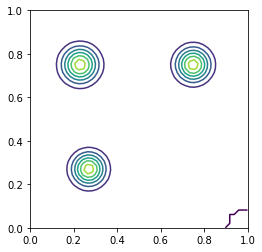

In [11]:
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))
# plt.axis('equal')
plt.axis('square')

Compute the Fourier basis modes and the orthonormalization factors
----

In [12]:
k1, k2 = np.meshgrid(*[np.arange(0, 20, step=1)]*2)

k = np.stack([k1.ravel(), k2.ravel()]).T
# k = np.pi*k
# lamk = (1.+np.linalg.norm(k,axis=1)**2)**(-4./2.)
lamk = np.exp(-0.8 * np.linalg.norm(k, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

Compute $\phi_k$'s and reconstruct to verify 
---

(0.0, 1.0, 0.0, 1.0)

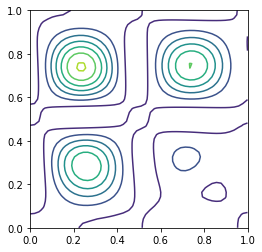

In [13]:
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(_s, k), vmap(p)(_s))
phik = phik/phik[0]
# phik = phik/np.array(hk)

phik_recon = np.dot(phik, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, phik_recon)
plt.axis('square')

Set up initial conditions and optimization states
----

In [16]:
x0 = np.array([0.54,0.3])

# U AND \LAMBDA ARE ABORBED INTO THE SAME VARIABLE FOR SIMPLICITY
num_samples = 100
u = np.zeros((num_samples,2))
u = cat([u, np.ones((num_samples,1))], axis=1)
# key = jnp_random.PRNGKey(0)
# u = jnp_random.normal(key, shape=(100, 3)) * 0.01 #+ np.array([0.5,0.5, 0.5])

# veryify that initial conditions are well defined by passing them through the 
# ergodic loss 
fourier_ergodic_loss(u, x0, phik, k)

# here we use adam as the optimizer but that is not required 
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(u)

Optimization loop 
---

The optimizaiton problem we are solving is the following: 

$$
\begin{align}
&& {\arg\min}_{\lambda(t), u(t) \forall t \in [0, T]} \mathcal{E}(x(t)) + \mathcal{J}_\text{barrier}(x(t)) + \int_t \vert \lambda(t) \vert dt \\ 
&& \text{ subject to } \dot{x} = f(x, u), 0 < \lambda(t) < 1, x(0) = x_0 \\ 
\end{align}
$$

where $\mathcal{J}_\text{barrier}$ is a barrier cost function and the last term is an $\ell_1$ penalty. 

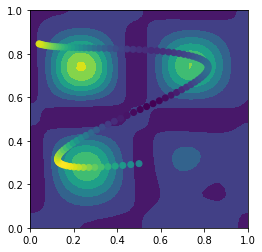

In [17]:
log = []
for i in range(300):
    g = dl(get_params(opt_state), x0, phik, k)
    opt_state = opt_update(i, g, opt_state)
    
    if (i+1) % 20 == 0:
        u = get_params(opt_state)
        #print(fourier_ergodic_loss(u, x0, phik, k))
        #new_u = cat([np.reshape(u[:,0],(num_samples,1)), np.reshape(u[:,1],(num_samples,1))], axis=1)
        #u = cat([new_u, np.ones((num_samples,1))], axis=1)
        log.append(fourier_ergodic_loss(u, x0, phik, k).copy())
        clear_output(wait=True)
        xf, tr = scan(f, x0, u)
        
        clear_output(wait=True)
        plt.contourf(X, Y, phik_recon)
        plt.scatter(tr[:,0],tr[:,1], c=sigmoid(5*u[:,2]))
        plt.axis('square')
#         plt.ylim(0,1)
#         plt.xlim(0,1)
        plt.pause(0.0001)
        i+=1
        plt.show()

#print(tr[:,0])
#print(tr[:,1])


(0.0, 1.0, 0.0, 1.0)

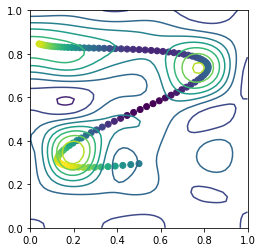

In [18]:
# ck = get_ck(tr, k)
ck = get_ck_weighted(tr, k, u[:,2])
ck_recon = np.dot(ck, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, ck_recon)
plt.scatter(tr[:,0],tr[:,1], c=u[:,2])
plt.axis('square')

In [19]:
import math

MSE = np.square(np.subtract(phik_recon,ck_recon)).mean() 
 
RMSE = math.sqrt(MSE)

print(RMSE)

5.340127531378966


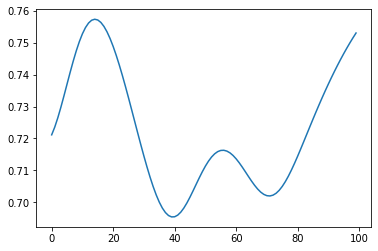

In [20]:
plt.plot(u[:,2])

In [21]:
print(fourier_ergodic_loss(u, x0, phik, k))

0.073772356


In [22]:
new_u = cat([np.reshape(u[:,0],(num_samples,1)), np.reshape(u[:,1],(num_samples,1))], axis=1)
u = cat([new_u, np.ones((num_samples,1))], axis=1)
print(fourier_ergodic_loss(u, x0, phik, k))

0.101691395


In [23]:
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

x = ['50', '100', '150', '200', '250', '300', '350', '400', '450', '500']
y = ['100', '90', '80', '70', '60', '50']

i1 = [81, 95, 84, 81, 87, 86, 80, 80, 85, 81]
i2 = [75, 100, 84, 94, 92, 74, 84, 68, 76, 86]
i3 = [98, 92, 80, 96, 94, 64, 76, 82, 70, 76]
i4 = [94, 98, 82, 98, 100, 78, 74, 86, 74, 66]
i5 = [96, 94, 76, 94, 92, 72, 80, 72, 76, 78]
i6 = [92, 96, 72, 100, 98, 84, 72, 80, 82, 76]

data = np.array([i1, i2, i3, i4, i5, i6])

fig, ax = plt.subplots()
im = ax.imshow(data)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(y)))
# ... and label them with the respective list entries
ax.set_xticklabels(x)
ax.set_yticklabels(y)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage of targets found', rotation=-90, va="bottom")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
'''for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, data[i, j],
                       ha="center", va="center", color="w")'''

ax.set_title("Percentage of targets found using different \n numbers of samples on inaccuracte information maps")
fig.tight_layout()
plt.show()
"""

'\nimport numpy as np\nimport matplotlib\nimport matplotlib.pyplot as plt\n\nvegetables = ["cucumber", "tomato", "lettuce", "asparagus",\n              "potato", "wheat", "barley"]\nfarmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",\n           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]\n\nx = [\'50\', \'100\', \'150\', \'200\', \'250\', \'300\', \'350\', \'400\', \'450\', \'500\']\ny = [\'100\', \'90\', \'80\', \'70\', \'60\', \'50\']\n\ni1 = [81, 95, 84, 81, 87, 86, 80, 80, 85, 81]\ni2 = [75, 100, 84, 94, 92, 74, 84, 68, 76, 86]\ni3 = [98, 92, 80, 96, 94, 64, 76, 82, 70, 76]\ni4 = [94, 98, 82, 98, 100, 78, 74, 86, 74, 66]\ni5 = [96, 94, 76, 94, 92, 72, 80, 72, 76, 78]\ni6 = [92, 96, 72, 100, 98, 84, 72, 80, 82, 76]\n\ndata = np.array([i1, i2, i3, i4, i5, i6])\n\nfig, ax = plt.subplots()\nim = ax.imshow(data)\n\n# We want to show all ticks...\nax.set_xticks(np.arange(len(x)))\nax.set_yticks(np.arange(len(y)))\n# ... and label them with the respective list 